# Presentation of new pyALF features

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF:

In [1]:
# Activate matplotlib Jupyter widgets
%matplotlib widget

In [2]:
import numpy as np

from py_alf import ALF_source, Simulation  # Interface with ALF

In [3]:
alf_src = ALF_source()

**2.** Create an instance of `Simulation`, setting parameters as desired:

**New:** Proper support for Parallel Tempering

In [4]:
sim = Simulation(
    alf_src,
    "Hubbard",
    [{
        'L1': 4,
        'L2': 4,
        "Nsweep": 1,
        "Nbin": 1000,
        "Lattice_type": "Square",
        "Ham_U": U,
        "mpi_per_parameter_set": 1
    } for U in [1, 2, 3, 4]
    ],
    n_mpi=4,
    machine='gnu',
    # parallel_params=True  # This option enables independent simulations in parallel.
)

**3.** Compile ALF, downloading it first from the [ALF repository](https://github.com/ALF-QMC/ALF/-/tree/master/) if not found locally. This may take a few minutes:

In [5]:
sim.compile()

Compiling ALF... 
Cleaning up Prog/
Cleaning up Libraries/
Cleaning up Analysis/
Compiling Libraries


ar: creating modules_90.a
ar: creating libqrref.a


Compiling Analysis
Compiling Program
Parsing Hamiltonian parameters
filenames: Hamiltonians/Hamiltonian_Kondo_smod.F90 Hamiltonians/Hamiltonian_Kondo_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_Hubbard_smod.F90 Hamiltonians/Hamiltonian_Hubbard_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_Hubbard_Plain_Vanilla_smod.F90 Hamiltonians/Hamiltonian_Hubbard_Plain_Vanilla_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_tV_smod.F90 Hamiltonians/Hamiltonian_tV_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_LRC_smod.F90 Hamiltonians/Hamiltonian_LRC_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_Z2_Matter_smod.F90 Hamiltonians/Hamiltonian_Z2_Matter_read_write_parameters.F90
filenames: Hamiltonians/Hamiltonian_Spin_Peierls_smod.F90 Hamiltonians/Hamiltonian_Spin_Peierls_read_write_parameters.F90
Compiling program modules
Link program
Done.


**4.** Perform the simulation as specified in `sim`:

In [6]:
sim.run()

Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/ALF.out
 ALF Copyright (C) 2016 - 2022 The ALF project contributors
 This Program comes with ABSOLUTELY NO WARRANTY; for details see license.GPL
 This is free software, and you are welcome to redistribute it under

**New:** Derived observables

In [7]:
custom_obs = {}

In [8]:
def obs_squared(obs, sign, N_obs):
    return obs**2 / sign

# Energy squared
custom_obs['E_squared']= {
    'needs': ['Ener_scal'],
    'function': obs_squared,
    'kwargs': {}
}

In [9]:
def E_pot_kin(E_pot_obs, E_pot_sign, E_pot_N_obs, E_kin_obs, E_kin_sign, E_kin_N_obs):
    return E_pot_obs/E_kin_obs / (E_pot_sign/E_kin_sign)

# Potential Energy / Kinetic Energy
custom_obs['E_pot_kin']= {
    'needs': ['Pot_scal', 'Kin_scal'],
    'function': E_pot_kin,
    'kwargs': {}
}

In [10]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=((0., 0.),), mat=None, NNs=((1, 0), (0, 1), (-1, 0), (0, -1))):
    """RG-invariant quantity derived from a correlatian function.

    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

# RG-invariant quantity for ferromagnetic order
custom_obs['R_Ferro']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[0., 0.]]}
}

# RG-invariant quantity for antiferromagnetic order
custom_obs['R_AFM']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[np.pi, np.pi]]}
}

**New:** Check warmup and autocorrelation

In [11]:
sim.check_warmup(
    ['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'],
    custom_obs=custom_obs, gui='ipy'
)

In [12]:
sim.check_rebin(
    ['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'],
    custom_obs=custom_obs, gui='ipy'
)

**New:** Lattice symmetries in analysis

In [13]:
# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
sym_c4 = [
    lambda latt, i : i,
    lambda latt, i : latt.rotate(i, np.pi*0.5),
    lambda latt, i : latt.rotate(i, np.pi),
    lambda latt, i : latt.rotate(i, np.pi*1.5),
]

**5.** Perform anaylsis:

In [14]:
sim.analysis(symmetry=sym_c4, custom_obs=custom_obs, always=True)

### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau


/home/jonas/Programs/pyALF/py_alf/ana.py:604: RuntimeWarning: invalid value encountered in divide
  J = J_obs[:, n] / J_sign


Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
Sp

In [15]:
import py_alf

In [16]:
py_alf.lattice.__file__

'/home/jonas/Programs/pyALF/py_alf/lattice.py'

**6.** Read analysis results:

In [17]:
obs = sim.get_obs()

/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0
No orbital locations saved.
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1
No orbital locations saved.
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2
No orbital locations saved.
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3
No orbital locations saved.


In [18]:
obs

,continuous,ham_chem,ham_t,ham_t2,ham_tperp,ham_u,ham_u2,mz,l1,l2,...,SpinXY_tauK_err,SpinXY_tauR,SpinXY_tauR_err,SpinXY_tau_lattice,SpinZ_tauK,SpinZ_tauK_err,SpinZ_tauR,SpinZ_tauR_err,SpinZ_tau_lattice,lattice
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,0,0.0,1.0,1.0,1.0,1.0,4.0,1,4,4,...,"[[0.0007537829802755554, 0.001000906647822049,...","[[0.009944787718874703, -0.08311991130989815, ...","[[0.00016119836510819082, 0.000320431318209926...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.5746678642065038, 0.4042353378830647, 0.57...","[[0.002771160278785636, 0.0015890557936291962,...","[[0.009347278398136873, -0.08365604986949807, ...","[[0.0012839431818822365, 0.0011546500918624566...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'N_coord'..."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,0,0.0,1.0,1.0,1.0,2.0,4.0,1,4,4,...,"[[0.00243178709851971, 0.0031264318540468717, ...","[[0.03469925779297676, -0.1113870792700236, 0....","[[0.0029576766486150313, 0.0017367631289594355...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6400538395583246, 0.4237024240459534, 0.64...","[[0.0054505382463837185, 0.0033465035246786705...","[[0.022933985952036797, -0.1036764359404749, 0...","[[0.0024872787974700708, 0.0022508565991350466...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'N_coord'..."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,0,0.0,1.0,1.0,1.0,3.0,4.0,1,4,4,...,"[[0.011851456553077474, 0.013262590165838991, ...","[[0.06234798458703581, -0.14978134845161875, 0...","[[0.004102466046595173, 0.003382323820260804, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6498125733916295, 0.44141749232737665, 0.6...","[[0.007298412258979233, 0.005252665127658649, ...","[[0.05339669939181033, -0.1421562399096341, 0....","[[0.0038862863294476173, 0.0036060845706908087...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'N_coord'..."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,0,0.0,1.0,1.0,1.0,4.0,4.0,1,4,4,...,"[[0.011884911308827534, 0.019066548206282306, ...","[[0.10215031272652919, -0.21160663260411136, 0...","[[0.008147602010680762, 0.008181955281427997, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6691865384045091, 0.43923305653759226, 0.6...","[[0.009538550016699227, 0.006805408791524047, ...","[[0.10742510637022053, -0.21136486261390217, 0...","[[0.0055316434433876046, 0.00498201475247216, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'N_coord'..."


which are available for further analyses. For instance, the internal energy of the system (and its error) is accessed by:

In [19]:
obs[['ham_u', 'Ener_scal0', 'Ener_scal0_err', 'Ener_scal_sign', 'E_pot_kin', 'E_pot_kin_err', 'R_Ferro', 'R_AFM']]

,ham_u,Ener_scal0,Ener_scal0_err,Ener_scal_sign,E_pot_kin,E_pot_kin_err,R_Ferro,R_AFM
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,1.0,-20.374940,0.005014,1.0,-0.144617,0.000079,-0.525188,0.353817
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,2.0,-17.388774,0.010125,1.0,-0.252498,0.000221,-0.436306,0.463888
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,3.0,-14.991747,0.016534,1.0,-0.328918,0.000483,-0.388749,0.575287
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,4.0,-13.218855,0.021768,1.0,-0.372193,0.000828,-1.232600,0.722344


<ErrorbarContainer object of 3 artists>

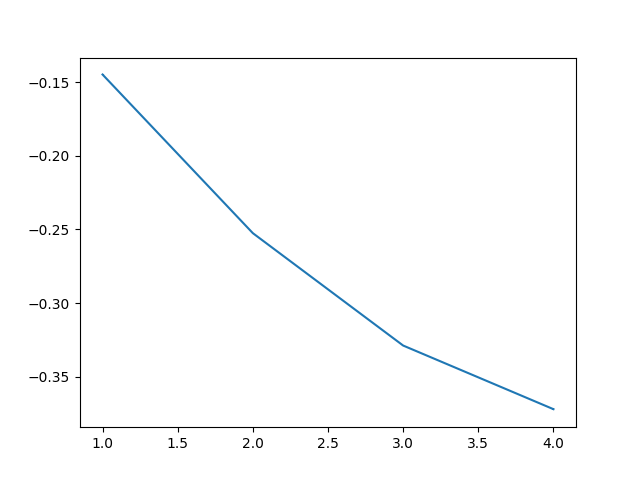

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.errorbar(obs.ham_u, obs.E_pot_kin, obs.E_pot_kin_err)

**New:** 2dplot on bravais lattice

In [21]:
from py_alf import Lattice

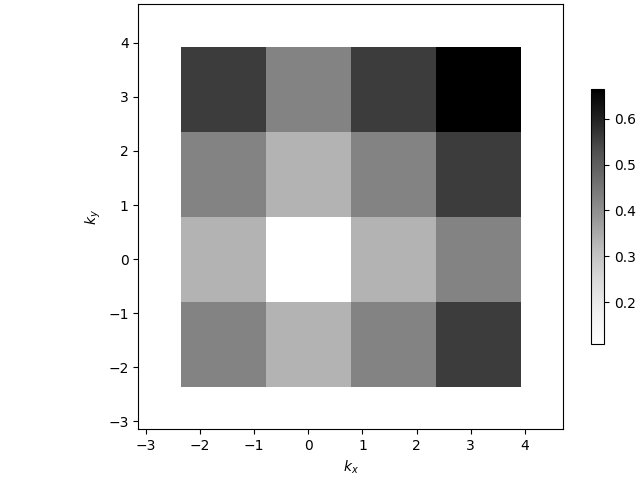

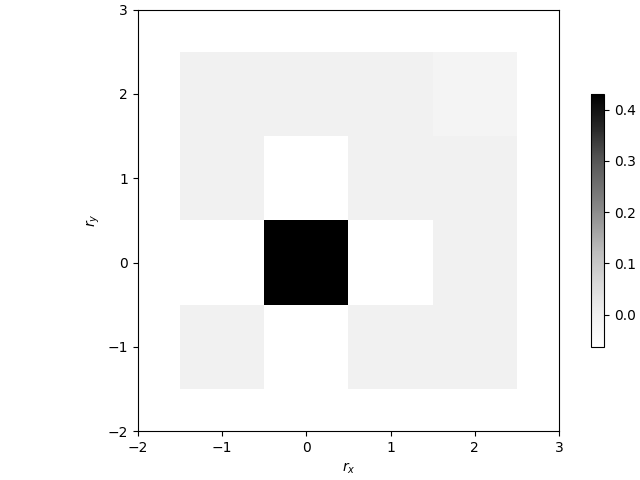

In [22]:
item = obs.iloc[0]

latt = Lattice(item.Den_eq_lattice)

latt.plot_k(item.Den_eqK[0, 0])
latt.plot_r(item.Den_eqR[0, 0])